In [1]:
""" 
The algorithm is tested on the PDSystemEnv  gym task 
and developed with Tensorflow

Author: Daniel Salgado Rojo
"""
import tensorflow as tf
import numpy as np
import gym
import gym_pdsystem
from gym import wrappers
#import tflearn
import argparse
import pprint as pp

#from ddpg.replay_buffer import ReplayBuffer

from datetime import datetime

import random
from gym_pdsystem.envs.pdsystem_env import PDSystemEnv

import gym_pdsystem.utils.utilsq as ut
import gym_pdsystem.utils.constants as ct


from matplotlib import animation, rc
import matplotlib.pyplot as plt
from IPython.display import HTML

import time

from functools import partial

#TO OMMIT WARNINGS
import warnings
warnings.filterwarnings('ignore')

def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)


/home/dsalgador/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
###########################################################
# Example n=5, k = 2

TANK_MAX_LOADS = np.array([100., 200, 100., 800., 200.])
LEVEL_PERCENTAGES = np.array([ #b , c, e
                                                [0.02, 0.31, 0.9],
                                                [0.01, 0.03, 0.9],
                                                [0.05, 0.16, 0.9],
                                                [0.07, 0.14, 0.85],
                                                [0.08, 0.26, 0.9]
                                                   ])

TRUCK_MAX_LOADS = np.array([70.,130.])

GRAPH_WEIGHTS = np.array([32., 159., 162., 156.,156., 0.])
DISCRETE = True
############################################################



###########################################################
# Example n=9, k = 3

TANK_MAX_LOADS = np.array([100., 200, 100., 800., 200., 500., 300., 800., 300.])
LEVEL_PERCENTAGES = np.array([ #b , c, e
                                                [0.02, 0.31, 0.9],
                                                [0.01, 0.03, 0.9],
                                                [0.05, 0.16, 0.9],
                                                [0.07, 0.14, 0.85],
                                                [0.08, 0.26, 0.9],
                                                [0.02, 0.31, 0.9],
                                                [0.01, 0.03, 0.9],
                                                [0.05, 0.16, 0.9],
                                                [0.07, 0.14, 0.85]
                                                   ])

TRUCK_MAX_LOADS = np.array([70.,130.,250.])

GRAPH_WEIGHTS = np.array([32., 159., 162., 156.,156., 32., 159., 162., 156., 0.])
DISCRETE = True
############################################################



# ###########################################################
# 	# Example n=11, k = 3

# 	TANK_MAX_LOADS = np.array([100., 200, 100., 800., 200., 500., 300., 800., 300.,600.,900.])
# 	LEVEL_PERCENTAGES = np.array([ #b , c, e
# 	                                                [0.02, 0.31, 0.9],
# 	                                                [0.01, 0.03, 0.9],
# 	                                                [0.05, 0.16, 0.9],
# 	                                                [0.07, 0.14, 0.85],
# 	                                                [0.08, 0.26, 0.9],
# 	                                                [0.02, 0.31, 0.9],
# 	                                                [0.01, 0.03, 0.9],
# 	                                                [0.05, 0.16, 0.9],
# 	                                                [0.07, 0.14, 0.85],
# 	                                                [0.01, 0.03, 0.9],
# 	                                                [0.01, 0.03, 0.9]

# 	                                                   ])

# 	TRUCK_MAX_LOADS = np.array([70.,130.,250.])

# 	GRAPH_WEIGHTS = np.array([32., 159., 162., 156.,156., 32., 159., 162., 156.,150.,150., 0.])
# 	DISCRETE = True
# 	############################################################
    
    
###########################################################
# Example n=12, k = 3

TANK_MAX_LOADS = np.array([100., 200, 100., 800., 200., 500., 300., 800., 300.,600.,900.,700.])
LEVEL_PERCENTAGES = np.array([ #b , c, e
                                                [0.02, 0.31, 0.9],
                                                [0.01, 0.03, 0.9],
                                                [0.05, 0.16, 0.9],
                                                [0.07, 0.14, 0.85],
                                                [0.08, 0.26, 0.9],
                                                [0.02, 0.31, 0.9],
                                                [0.01, 0.03, 0.9],
                                                [0.05, 0.16, 0.9],
                                                [0.07, 0.14, 0.85],
                                                [0.01, 0.03, 0.9],
                                                [0.01, 0.03, 0.9],
                                                [0.07, 0.14, 0.85]


                                                   ])

TRUCK_MAX_LOADS = np.array([70.,130.,250.])

GRAPH_WEIGHTS = np.array([32., 159., 162., 156.,156., 32., 159., 162., 156.,150.,150.,150., 0.])
DISCRETE = True
############################################################


env = gym.make("PDSystemEnv-v0")
episode_length = 30
env._max_episode_steps = episode_length



In [3]:
def int_to_action(int_action: int, env):
    """
    So far assumed k = 2 or 3:
    
    Converts an integer between 0 and env.action_space.shape[1]**env.action_space.shape[0]
    which is (n+1)^k where n is the number of tanks and k the number of trucks.
    
    return vect_action: a k-dimensional vector with components in the range 0,...n. 
    For k = 2, vect_action = [i,j] is the action of truck 1 going to tank i and truck 2 going to tank j.
    (i, j = n means staying at the depot, 0,....,n-1 are the real tanks).
    The associated integer is i*(n+1) + j
    
    For k = 3, vect_action = [i,j,l] is the action of truck 1 going to tank i, truck 2 going to tank j,
    and truck 3 going to tank l.
    (i, j, l = n means staying at the depot, 0,....,n-1 are the real tanks).
    The associated integer is (i*(n+1) + j)*(n+1) + l

    """
    nplus1 = env.action_space.shape[1]
    k = env.action_space.shape[0]
    n_actions = nplus1**k
    
    if k == 2:
        j = int_action % nplus1
        i = int((int_action-j)/nplus1)
        vect_action = np.array([i,j])
      
    elif k == 3:
        l = int_action % nplus1
        ij = int( (int_action - l)/nplus1 ) 
        j = ij % nplus1
        i = int((ij-j)/nplus1)
        vect_action = np.array([i,j,l])
    
    else:
        raise ValueError("The number of trucks k of the environment is different from 2 or 3")
    return vect_action

def action_to_int(vect_action: np.array, env):
    """
    Assumed k = 2 or 3, so vect_action has 2 or 3 components
    """
    nplus1 = env.action_space.shape[1]
    k = env.action_space.shape[0]
    if k == 2:
        int_action = vect_action[0] * nplus1 + vect_action[1]
    elif k == 3:
        int_action = (vect_action[0] * nplus1 + vect_action[1])*nplus1 + vect_action[2]
    else:
        raise ValueError("The number of trucks k of the environment is different from 2 or 3")

    return int_action
    

In [4]:
int_action = 66
print(int_action)
vect_action = int_to_action(int_action,env)
print(vect_action)
int_action = action_to_int(vect_action,env)
print(int_action)

66
[0 5 1]
66


In [5]:
"""
From https://github.com/ageron/handson-ml 
"""

def discount_rewards(rewards, discount_rate):
    discounted_rewards = np.zeros(len(rewards))
    cumulative_rewards = 0
    for step in reversed(range(len(rewards))):
        cumulative_rewards = rewards[step] + cumulative_rewards * discount_rate
        discounted_rewards[step] = cumulative_rewards
    return discounted_rewards

def discount_and_normalize_rewards(all_rewards, discount_rate):
    all_discounted_rewards = [discount_rewards(rewards, discount_rate) for rewards in all_rewards]
    flat_rewards = np.concatenate(all_discounted_rewards)
    reward_mean = flat_rewards.mean()
    reward_std = flat_rewards.std()
    return [(discounted_rewards - reward_mean)/reward_std for discounted_rewards in all_discounted_rewards]

In [6]:
reset_graph()

# TensorBoard summary directories
now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
root_logdir = "tf_logs"
logdir = "{}/run-{}/".format(root_logdir, now)   


seed = 42
np.random.seed(seed)

learning_rate = 0.01 #0.01

hidden1_neurons = 100 #100
hidden2_neurons = 50 #50

batch_normalization = True  
batch_norm_momentum = 0.9



with tf.name_scope("dnn"):
            tf.set_random_seed(seed)
        
            # 1. Parameters to determine the NN architecture

            n_inputs = env.observation_space.shape[1]
            n_hidden1 = hidden1_neurons; activation1 = tf.nn.sigmoid#tf.nn.elu
            n_hidden2 = hidden2_neurons; activation2 = tf.nn.sigmoid#tf.nn.elu
            n_outputs = env.action_space.shape[1]**env.action_space.shape[0]
            
            he_init = tf.contrib.layers.variance_scaling_initializer()

            # 2. Build the Neural Network
#             training = tf.placeholder_with_default(False, shape=(), name='training')

            
#             my_batch_norm_layer = partial(
#                                             tf.layers.batch_normalization,
#                                             training=training,
#                                             momentum=batch_norm_momentum)

#             my_dense_layer = partial(
#                                         tf.layers.dense,
#                                         kernel_initializer=he_init)


            X = tf.placeholder(tf.float32, shape = (None, n_inputs), name = "X")
            
            
#             hidden1 = my_dense_layer(X, n_hidden1, name = "hidden1")
#             bn1 = activation1(my_batch_norm_layer(hidden1))
#             hidden2 = my_dense_layer(bn1, n_hidden2, name = "hidden2")
#             bn2 = activation2(my_batch_norm_layer(hidden2))

            
            hidden1 = tf.layers.dense(X, n_hidden1, activation = activation1,
                                     kernel_initializer = he_init)
            hidden2 = tf.layers.dense(hidden1, n_hidden2, activation = activation2,
                                     kernel_initializer = he_init)
            logits = tf.layers.dense(hidden2, n_outputs, name = "logits")#,kernel_initializer = initializer)
            outputs = tf.nn.softmax(logits)
                   
            
with tf.name_scope("action"):
            # 3. Select a random action (where to go) based on the estimated probabilities
            action = tf.multinomial(tf.log(outputs), num_samples = 1)
            #print(tf.rank(action))
            #action_onehot = tf.one_hot(indices, n_outputs)
            #y = tf.reshape(action_onehot[action], (n_outputs, None))
            #y = tf.Variable(action, tf.int64)
            y = tf.reshape(action, [1])
            #print(tf.rank(y))
            #print(tf.rank(logits))
            
with tf.name_scope("loss"):
            xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels = y,logits = logits)
#             xentropy = tf.nn.sigmoid_cross_entropy_with_logits(labels = y,
#                                                                       logits = logits)
            loss = tf.reduce_mean(xentropy, name = "loss")
            
tf.summary.scalar('average_cross_entropy', loss)


with tf.name_scope("train"):
            # Optimization Op
            optimizer = tf.train.AdamOptimizer(learning_rate)
            #optimize = optimizer.minimize(loss)
            
            grads_and_vars = optimizer.compute_gradients(xentropy)
            gradients = [grad for grad, variable in grads_and_vars]
            gradient_placeholders = []
            grads_and_vars_feed = []
            for grad, variable in grads_and_vars:
                gradient_placeholder = tf.placeholder(tf.float32, shape=grad.get_shape())
                gradient_placeholders.append(gradient_placeholder)
                grads_and_vars_feed.append((gradient_placeholder, variable))
            training_op = optimizer.apply_gradients(grads_and_vars_feed)

                        
# # with tf.name_scope("eval"):
# #             correct = tf.nn.in_top_k(logits, y, 1)
# #             accuracy = tf.reduce_mean(tf.cast(correct,tf.float32))
# # tf.summary.scalar('accuracy', accuracy)

#Extra summary scalars
#avg_disc_reward_per_game = tf.placeholder(tf.float32, name = "avg_disc_reward")
# reward_placeholder = tf.placeholder(tf.float32, name = "reward_placeholder")
# avg_disc_reward_per_game = tf.Variable(0.0,dtype = tf.float32, name = "avg_disc_reward")

# tf.summary.scalar("Average_Discounted_Reward_per_game", avg_disc_reward_per_game)
                                       
merged = tf.summary.merge_all()
init = tf.global_variables_initializer()
file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())
        
saver = tf.train.Saver()
        
    

Instructions for updating:
Use the retry module or similar alternatives.


In [8]:
# File names for the model

model_file = "./pdenv_policy_net_pg.ckpt"#.format(learning_rate)
graph_file =  '{}.meta'.format(model_file)


# Simulation / Training parameters
n_games_per_update = 10
n_max_steps = episode_length
n_iterations = 10**5
save_iterations = 100 # USEFUL WHEN USING EARLY STOPPING
discount_rate = 0.95


info_freq = 100
round_time = 2
round_reward = 6
#avg_rewards_list = []
summary_freq = 20#int(info_freq/2)

# Early stopping
max_checks_without_progress = 100 # one for each "info_freq" (in terms of iterations it would be
                                                            #max_checks_without_progress *  info_freq)
checks_without_progress = 0
best_reward = -np.infty


retrain = False
###########################

with tf.Session() as sess:
    
    #train_writer = tf.summary.FileWriter(logdir + '/pgtrain', sess.graph)
    if retrain:
        saver.restore(sess, model_file)
        
    summary2 = tf.Summary()
    if not retrain:
        init.run()
    time_start = time.time()

    for iteration in range(n_iterations+1):
        print("\rIteration: {}".format(iteration), end="")
        all_rewards = []
        all_gradients = []
        for game in range(n_games_per_update):
            current_rewards = []
            current_gradients = []
            obs = env.reset()
            for step in range(n_max_steps):
                action_val, gradients_val = sess.run([action, gradients], feed_dict={X: obs.reshape(1, n_inputs)}) 
                vect_action = int_to_action(action_val,env) #HERE WE CONVERT FROM INTEGER TO ACTION's Array
                obs, reward, done, info = env.step(vect_action)
                current_rewards.append(reward)
                current_gradients.append(gradients_val)                
                
                if done:
                    break
            all_rewards.append(current_rewards)
            all_gradients.append(current_gradients)
            
        
        all_disc_rewards = discount_and_normalize_rewards(all_rewards, discount_rate=discount_rate)
        feed_dict = {}
        for var_index, gradient_placeholder in enumerate(gradient_placeholders):
            mean_gradients = np.mean([reward * all_gradients[game_index][step][var_index]
                                      for game_index, rewards in enumerate(all_disc_rewards)
                                          for step, reward in enumerate(rewards)], axis=0)
            feed_dict[gradient_placeholder] = mean_gradients
         
       
        #tf.summary.scalar('avg_rewards', avg_rewards)
        #train_writer.add_summary(avg_rewards, iteration)

        # Summary and info printings     ###################################################################
        if iteration % info_freq == 0 or iteration % summary_freq == 0:  
            
            #avg_rewards =np.array([np.mean(np.array(all_rewards)) / n_games_per_update])
            avg_rewards =np.mean(np.array(all_rewards)) / n_games_per_update
#             print(avg_rewards)
            #avg_rewards_list.append(avg_rewards)
            if iteration % summary_freq == 0:
                summary2.value.add(tag='average_discounted_reward_per_game', simple_value = avg_rewards)
                file_writer.add_summary(summary2, iteration)

                feed_dict[X] = obs.reshape(1, n_inputs)
                summary = sess.run(merged, feed_dict= feed_dict)

                file_writer.add_summary(summary, iteration)
                
            if iteration % info_freq == 0:
                time_end = time.time()
                print(". Average reward per game: ",  round(avg_rewards, round_reward), 
                      ", Elapsed time ", round( (time_end-time_start)/60., round_time), " minutes.") 
                
                if avg_rewards > best_reward:
                    saver.save(sess, model_file)
                    best_reward = avg_rewards
                    checks_without_progress = 0
                else:
                    checks_without_progress += 1
                    if checks_without_progress > max_checks_without_progress:
                        print("Early stopping!")
                        break
        ####################################################################################################
        
        
        sess.run(training_op, feed_dict=feed_dict)
    
    #saver.save(sess, model_file + "final")
    file_writer.flush()
    file_writer.close()
             
        
        #if iteration % save_iterations == 0:
                  #saver.save(sess, model_file)
    
  

Iteration: 0. Average reward per game:  -0.542967 , Elapsed time  0.01  minutes.
Iteration: 100. Average reward per game:  -0.421455 , Elapsed time  0.9  minutes.
Iteration: 200. Average reward per game:  -0.347523 , Elapsed time  1.78  minutes.
Iteration: 300. Average reward per game:  -0.255325 , Elapsed time  2.67  minutes.
Iteration: 400. Average reward per game:  -0.285025 , Elapsed time  3.55  minutes.
Iteration: 500. Average reward per game:  -0.208267 , Elapsed time  4.44  minutes.
Iteration: 600. Average reward per game:  -0.248734 , Elapsed time  5.34  minutes.
Iteration: 700. Average reward per game:  -0.230413 , Elapsed time  6.23  minutes.
Iteration: 800. Average reward per game:  -0.202302 , Elapsed time  7.12  minutes.
Iteration: 900. Average reward per game:  -0.146286 , Elapsed time  8.03  minutes.
Iteration: 1000. Average reward per game:  -0.141048 , Elapsed time  8.93  minutes.
Iteration: 1100. Average reward per game:  -0.145207 , Elapsed time  9.84  minutes.
Itera

Iteration: 9700. Average reward per game:  -0.109319 , Elapsed time  93.88  minutes.
Iteration: 9800. Average reward per game:  -0.110607 , Elapsed time  94.81  minutes.
Iteration: 9900. Average reward per game:  -0.114924 , Elapsed time  95.79  minutes.
Iteration: 10000. Average reward per game:  -0.126138 , Elapsed time  96.71  minutes.
Iteration: 10100. Average reward per game:  -0.114525 , Elapsed time  97.71  minutes.
Iteration: 10200. Average reward per game:  -0.119034 , Elapsed time  98.71  minutes.
Iteration: 10300. Average reward per game:  -0.116843 , Elapsed time  99.64  minutes.
Iteration: 10400. Average reward per game:  -0.120587 , Elapsed time  100.55  minutes.
Iteration: 10500. Average reward per game:  -0.141069 , Elapsed time  101.56  minutes.
Iteration: 10600. Average reward per game:  -0.13639 , Elapsed time  102.48  minutes.
Iteration: 10700. Average reward per game:  -0.139377 , Elapsed time  103.41  minutes.
Iteration: 10800. Average reward per game:  -0.162257 

Iteration: 19200. Average reward per game:  -0.117992 , Elapsed time  188.64  minutes.
Iteration: 19300. Average reward per game:  -0.102121 , Elapsed time  189.72  minutes.
Iteration: 19400. Average reward per game:  -0.109492 , Elapsed time  190.66  minutes.
Iteration: 19500. Average reward per game:  -0.119129 , Elapsed time  191.58  minutes.
Iteration: 19600. Average reward per game:  -0.135105 , Elapsed time  192.58  minutes.
Iteration: 19700. Average reward per game:  -0.112058 , Elapsed time  193.66  minutes.
Iteration: 19800. Average reward per game:  -0.099848 , Elapsed time  194.67  minutes.
Iteration: 19900. Average reward per game:  -0.109466 , Elapsed time  195.61  minutes.
Iteration: 20000. Average reward per game:  -0.144258 , Elapsed time  196.52  minutes.
Iteration: 20100. Average reward per game:  -0.14868 , Elapsed time  197.45  minutes.
Iteration: 20200. Average reward per game:  -0.174156 , Elapsed time  198.43  minutes.
Iteration: 20300. Average reward per game:  

## PLAY:

In [9]:
seed = 45
np.random.seed(seed)

frames = []
n_episodes = 5

system = PDSystemEnv()

model_file = "pdenv_policy_net_pg.ckpt"

with tf.Session() as sess:
        sess.run(init)
        saver.restore(sess, model_file)
        for episode in range(n_episodes):
            state = env.reset()
            for step in range(episode_length):
                system.state = state
                img = system.visualize()
                frames.append(img)

                action_val = action.eval(feed_dict={X: state.reshape(1, n_inputs)})
                vect_action = int_to_action(action_val,env) #HERE WE CONVERT FROM INTEGER TO ACTION's Array
                #print(vect_action)
                state, reward, done, info = env.step(vect_action)
                #print(state)
                #print(action_val[0],emptiest_tank_policy(state, system))
        env.close()
    

INFO:tensorflow:Restoring parameters from pdenv_policy_net_pg.ckpt


In [10]:
test_anim = ut.create_system_animation(frames, n_episodes * episode_length)
plt.close()

HTML(test_anim.to_html5_video())

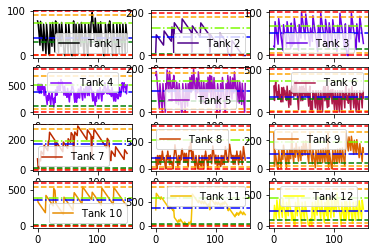

In [11]:
plt.close()

#THE REAL LEVELS (percentages 12h, 36h, ? h)
tank_levels = [frames[i][2] for i in range(len(frames))]
tank_levels_array = np.asarray(tank_levels).transpose()

n = system.n

cmap = plt.get_cmap('gnuplot')
colors = [cmap(i) for i in np.linspace(0, 1, n)]
lvl_colors = ["Orange", "Green","Orange"]

tanks_max_load = system.tank_max_loads
level_percentages = system.load_level_percentages

for i, color in enumerate(colors, start=1):
    plt.subplot(4,3, i)    

    plt.plot(tank_levels_array[i-1], color=color, label='Tank ${i}$'.format(i=i))
    
    plt.axhline(y= tanks_max_load[i-1], xmin=0, xmax=episode_length, hold=None, color = "Red", linestyle = '--')
    for lvl_color, lvl in zip(lvl_colors, level_percentages[i-1]):
        plt.axhline(y= lvl * tanks_max_load[i-1], xmin=0, xmax=episode_length, hold=None, color = lvl_color, 
                    linestyle = '--')
    plt.axhline(y= 0, xmin=0, xmax=episode_length, hold=None, color = "Red", linestyle = '--')
    
    
    percentages = level_percentages[i-1]           
    c = percentages[1]
    e = percentages[2]          
    d = ct.p0_GLOBAL*e+(1-ct.p0_GLOBAL)*c
    plt.axhline(y= d*tanks_max_load[i-1], xmin=0, xmax=episode_length, hold=None, color = "lawngreen", 
                linestyle = '-.')

    plt.axhline(y= np.mean(tank_levels_array[i-1]), xmin=0, xmax=episode_length, hold=None, 
                color = "blue", linestyle = '-.')
    
    plt.legend(loc='best')
plt.show()


In [ ]:
int_to_action(352,env)

In [ ]:
if 1 == 2 or 1 == 0:
    print(2)